In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# Оптимизация производственных расходов

In [2]:
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import seaborn as sns
pd.options.mode.chained_assignment = None
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Я построю модель, которая предскажет температуру стали.

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Также для начала импортируем все данные, чтобы хотя бы посмотреть что они из себя представляют

## Анализ данных и первичные выводы о датафреймах

### Импорт данных

In [3]:
data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')

In [4]:
def see(data):
    display(data.head(5))
    display(data.describe())
    display(data.info())
    display(data.isnull().sum())

### data_arc_new

In [5]:
see(data_arc_new)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

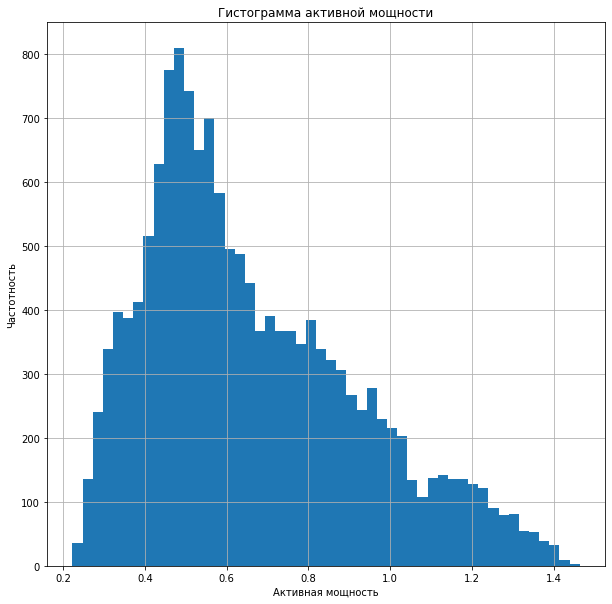

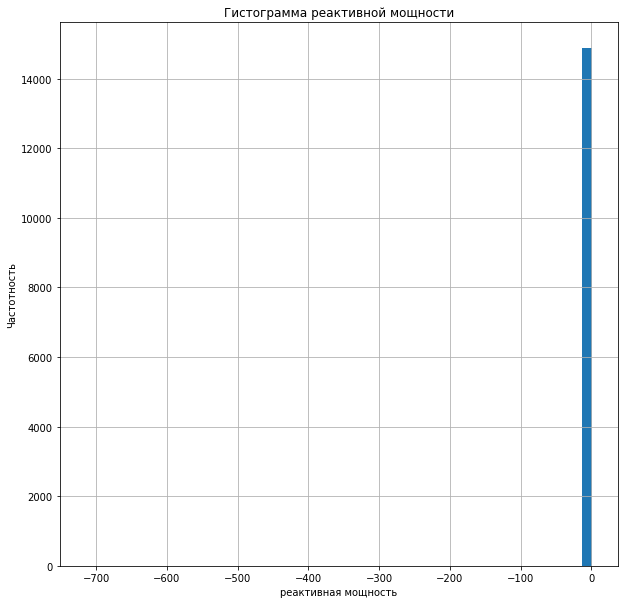

In [6]:
plt.rcParams['figure.figsize'] = [10, 10]
data_arc_new.hist(bins = 50, column = 'Активная мощность')
plt.title('Гистограмма активной мощности')
plt.xlabel('Активная мощность')
plt.ylabel('Частотность')
plt.show()
data_arc_new.hist(bins = 50, column = 'Реактивная мощность')
plt.title('Гистограмма реактивной мощности')
plt.xlabel('реактивная мощность')
plt.ylabel('Частотность')
plt.show()

1. Здесь мы видим что данные по активной мощности немного скошенны вправо, но не критично, выбросов и странных значений нету
2. Что касается реактивной мощности, то здесь данные имеют явно выраженные выбросы, которые нужно будет фиксить
3. Пропусков в данных нет
4. Для одной плавки нам нужно как то агреггировать данные, например суммировать мощности

### data_bulk_new and data_wire_new

In [7]:
see(data_bulk_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [8]:
see(data_wire_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Здесь достаточно много пропусков, но в данном случае пропуски обозначают лишь то, то в данной плавке присадки не добавлялись, можно в целом взять как признак, но не уверен, что нужно брать абсолютно все wire или bulk.

Строить гистограммы тоже в данном случае смысла не имеет, так как это все лишь присадка

Также стоит отметить что странных и нелогичных значений не было выявлено, есть только некоторые некритичные выбросы

### data_temp_new

In [9]:
see(data_temp_new)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


None

key                0
Время замера       0
Температура     3427
dtype: int64

Известно, что как признак мы можем взять только первую температуру, а как таргет - последнюю температуру

В случае пропуска в date_temp (а пропусков здесь много) считаю важным удалить всю партию целиком, также сделать общее время варки, начальную температуру, последнюю температуру, сделать это можно сгруппировав по партии.

Также построим гистограмму температур

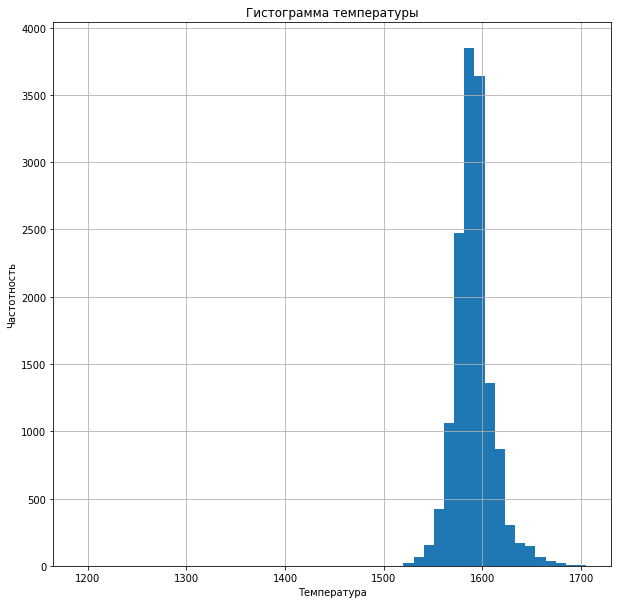

In [10]:
plt.rcParams['figure.figsize'] = [10, 10]
data_temp_new.hist(bins = 50, column = 'Температура')
plt.title('Гистограмма температуры')
plt.xlabel('Температура')
plt.ylabel('Частотность')
plt.show()

В данном датасете также не было выявлено выбросов и нелогичных значений (возможно температура плавления меньеш 1500 является ошибкой, но я не могу точно это сказать), данные скошены влево, но это не является критичным.

Конечно, при желании можно ограничить данные снизу на 1500 и сверху на 1700, и мне кажется я это сделаю, так как это поможет улучшить результат, а на реальности исследования скажется совсем некритично.

### data_bulk_time_new and data_wire_time_new

In [11]:
see(data_bulk_time_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [12]:
see(data_wire_time_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Данные датафреймы просто отображают время когда было залито то или иное вещество, не несут в себе достаточно полезной информации, скорее всего не буду использовать данные датафреймы

### data_gas_new

In [13]:
see(data_gas_new)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0
Газ 1    0
dtype: int64

Газ подается под сильным давлением и после того как в ковш подали дополнительно bulk и проводов перемешать это все, на первый взгляд не имеется какие то больших отклонений или нелогичных значений, пропусков также нет

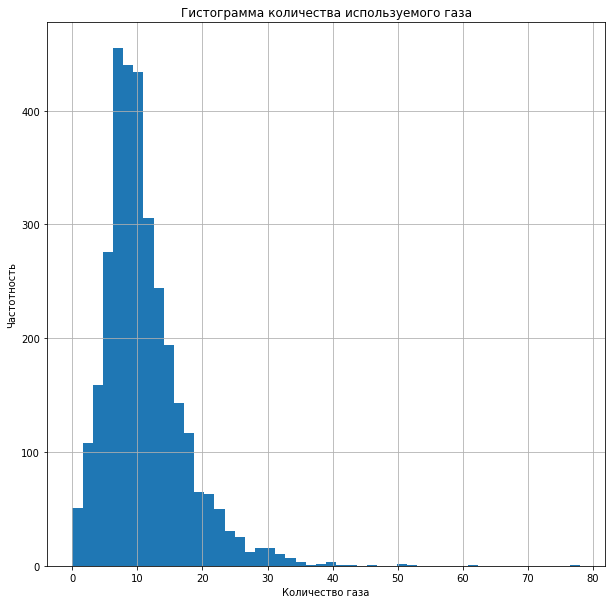

In [14]:
plt.rcParams['figure.figsize'] = [10, 10]
data_gas_new.hist(bins = 50, column = 'Газ 1')
plt.title('Гистограмма количества используемого газа')
plt.xlabel('Количество газа')
plt.ylabel('Частотность')
plt.show()

По результатам гистограммы данные очень сильно скошены вправо, возможно стоит отрезать данные до 40, но какие то нелогичных значений не присутствуют, все что выше 40 является выбросами

## План после первичного анализа данных:
1. Предобработка данных (удаление пропусков, фикс аномалий, возможно генерация каких то новых признаков)
2. Объединение всех данных в один датафрейм (изначально у нас данные в нескольких)
3. обработка данных в новом датафрейме (разделение на выборки, масштабирование при необходимости, выделение признаков)
4. Далее мы будем готовы обучать модель, мои любимые модели это кэтбуст и случайный лес, их я и буду использовать вместе с гридсерчем.
5. Далее проверим качество всех моделей и лучшую протестируем на тестовой выборке..


Думаю, что это все, вопрос каких то у меня не возникало

# Оптимизация производственных расходов

## План после первичного анализа данных:
1. Предобработка данных (удаление пропусков, фикс аномалий, возможно генерация каких то новых признаков)
2. Объединение всех данных в один датафрейм (изначально у нас данные в нескольких)
3. обработка данных в новом датафрейме (разделение на выборки, масштабирование при необходимости, выделение признаков)
4. Далее мы будем готовы обучать модель, мои любимые модели это кэтбуст и случайный лес, их я и буду использовать вместе с гридсерчем.
5. Далее проверим качество всех моделей и лучшую протестируем на тестовой выборке..


## Предобработка данных

### Data_arc_new предобработка

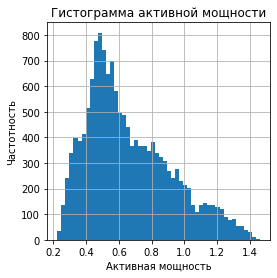

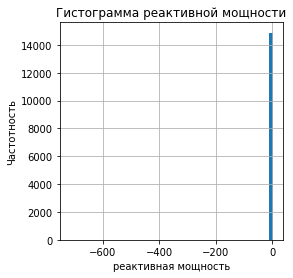

In [15]:
plt.rcParams['figure.figsize'] = [4, 4]
data_arc_new.hist(bins = 50, column = 'Активная мощность')
plt.title('Гистограмма активной мощности')
plt.xlabel('Активная мощность')
plt.ylabel('Частотность')
plt.show()
data_arc_new.hist(bins = 50, column = 'Реактивная мощность')
plt.title('Гистограмма реактивной мощности')
plt.xlabel('реактивная мощность')
plt.ylabel('Частотность')
plt.show()

Как уже было сказано выше, мощность не может быть отрицательной, поэтому придется поработать над всеми упоминаниями отрицательной реактивной мощности, что касается активной мощности, с ней все хорошо

In [16]:
data_arc_new = data_arc_new.groupby('key').agg(['sum', 'min'])

In [17]:
data_arc_new.columns = ['bts', 'btm', 'ets', 'etm','active_power_sum', 'active_power_min', 'reactive_power_sum', 'reactive_power_min']

In [18]:
data_arc_new = data_arc_new[(data_arc_new['reactive_power_min'] >= 0)]

Теперь мы можем удалить 2 ненужных столбца, а именно минимальное значение так как оно было нужно только чтобы отфильтровать датасет

In [19]:
data_arc_new = data_arc_new.drop(['bts', 'btm', 'ets', 'etm','active_power_min', 'reactive_power_min'], axis = 1)

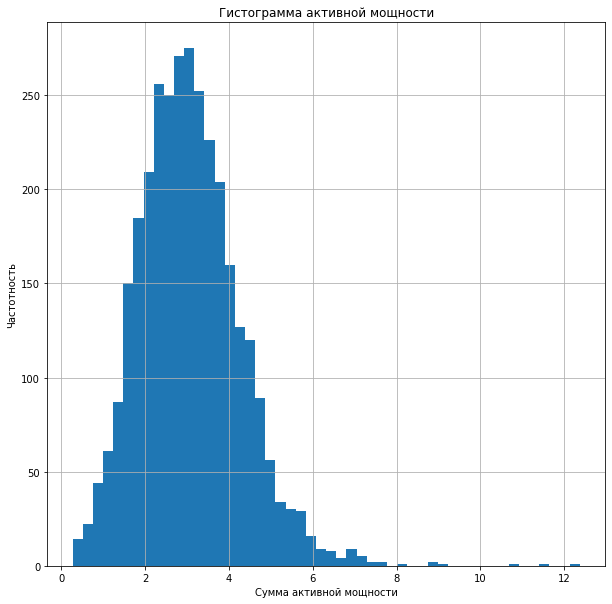

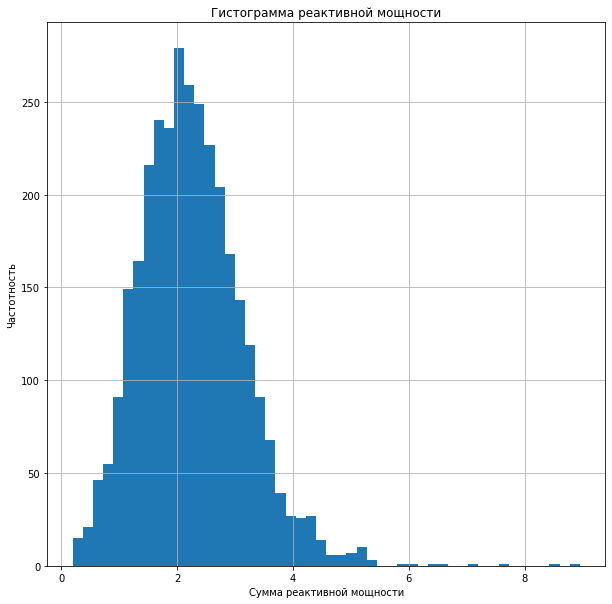

In [20]:
plt.rcParams['figure.figsize'] = [10, 10]
data_arc_new.hist(bins = 50, column = 'active_power_sum')
plt.title('Гистограмма активной мощности')
plt.xlabel('Сумма активной мощности')
plt.ylabel('Частотность')
plt.show()
data_arc_new.hist(bins = 50, column = 'reactive_power_sum')
plt.title('Гистограмма реактивной мощности')
plt.xlabel('Сумма реактивной мощности')
plt.ylabel('Частотность')
plt.show()

Теперь распределение без нелогичных значений, но все еще смещено вправо, но это в целом не критично

Также стоит в целом еще раз посмотреть на описательную статистику после предобработки

In [21]:
see(data_arc_new)

,active_power_sum,reactive_power_sum
key,,
1,3.036730,2.142821
2,2.139408,1.453357
3,4.063641,2.937457
4,2.706489,2.056992
5,2.252950,1.687991


,active_power_sum,reactive_power_sum
count,3213.000000,3213.000000
mean,3.067683,2.254693
std,1.208719,0.894787
min,0.267676,0.196228
25%,2.236693,1.631855
50%,2.984607,2.177210
75%,3.775574,2.788381
max,12.375636,8.949049


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   active_power_sum    3213 non-null   float64
 1   reactive_power_sum  3213 non-null   float64
dtypes: float64(2)
memory usage: 75.3 KB


None

active_power_sum      0
reactive_power_sum    0
dtype: int64

В данных не обнаружено аномалий, все хорошо

### data_bulk_new and data_wire_new предобработка

Данные по сыпучим материалам и проволке также стоит обработать, так как я буду их брать как признаки, все пропуски заменим нулями, возьму только 3,4,6, 12,14,15 добавление сыпучих материалов, так как в остальных больше 95% нулей, а это будет только перегружать модель. Что касается проволоки, то здесь возьму только 2 первых добавления, так как в остальных тоже нулей больше чем 95%, что также будет перегружать модель.

Также я подумал, что можно просто засуммировать все добавления, чтобы не перегружать модель (скажите если так будет лучше пожалуйста), но пока что я оставлю так

In [22]:
data_bulk_new = data_bulk_new[['key','Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15']]
data_wire_new = data_wire_new[['key','Wire 1', 'Wire 2']]

In [23]:
data_bulk_new = data_bulk_new.fillna(0)
data_wire_new = data_wire_new.fillna(0)

Также стоит еще раз взглянуть на данные после предобработки

In [24]:
see(data_bulk_new)

,key,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15
0,1,0.0,43.0,0.0,206.0,150.0,154.0
1,2,0.0,73.0,0.0,206.0,149.0,154.0
2,3,0.0,34.0,0.0,205.0,152.0,153.0
3,4,0.0,81.0,0.0,207.0,153.0,154.0
4,5,0.0,78.0,0.0,203.0,151.0,152.0


,key,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,47.240332,33.830617,21.892298,203.948226,152.706616,115.319271
std,933.337642,74.239954,56.034505,55.492582,151.419639,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,105.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,206.000000,148.000000,106.000000
75%,2431.000000,80.000000,68.000000,0.000000,263.000000,202.000000,204.000000
max,3241.000000,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 3   3129 non-null   float64
 2   Bulk 4   3129 non-null   float64
 3   Bulk 6   3129 non-null   float64
 4   Bulk 12  3129 non-null   float64
 5   Bulk 14  3129 non-null   float64
 6   Bulk 15  3129 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 171.2 KB


None

key        0
Bulk 3     0
Bulk 4     0
Bulk 6     0
Bulk 12    0
Bulk 14    0
Bulk 15    0
dtype: int64

In [25]:
see(data_wire_new)

,key,Wire 1,Wire 2
0,1,60.059998,0.00000
1,2,96.052315,0.00000
2,3,91.160157,0.00000
3,4,89.063515,0.00000
4,5,89.238236,9.11456


,key,Wire 1,Wire 2
count,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733
std,932.996726,42.841120,33.517734
min,1.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000
50%,1619.000000,100.114563,0.000000
75%,2434.000000,125.798405,23.162880
max,3241.000000,330.314424,282.780152


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 72.3 KB


None

key       0
Wire 1    0
Wire 2    0
dtype: int64

Эти данные после предобработки также стали гораздо более подходящими для обучения моделей

### data_temp_new предобработка

Здесь для начала я удалю все строки, где в замерах температуры происходил сбой

In [26]:
data_temp_new.isnull().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

In [27]:
has_null = data_temp_new.groupby('key')['Температура'].apply(lambda x: x.isnull().any())
keys_with_null = has_null[has_null].index
data_temp_new = data_temp_new[~data_temp_new['key'].isin(keys_with_null)]

In [28]:
keys_with_low_temp = data_temp_new[data_temp_new['Температура'] < 1450]['key'].unique()
data_temp_new = data_temp_new[~data_temp_new['key'].isin(keys_with_low_temp)]

In [29]:
data_temp_new.isnull().sum()

key             0
Время замера    0
Температура     0
dtype: int64

Все пропуски были удалены

In [30]:
data_temp_new[data_temp_new['Температура'] < 1450]

,key,Время замера,Температура


Все значения и ключи в которых присутствовала температура меньше 1450 удалены

In [31]:
data_temp_new = data_temp_new[data_temp_new['key'].isin(data_temp_new.groupby('key').count().query('Температура > 1').reset_index()['key'])]

In [32]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13903 non-null  int64  
 1   Время замера  13903 non-null  object 
 2   Температура   13903 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


Здесь необходимо добавить 2 новых признака (первую температуру и последнюю температуру), а также добавить признак который касается времени плавления

In [33]:
data_temp_new = data_temp_new.groupby('key').agg({'Температура': ['first', 'last', 'min'], 'Время замера': ['first', 'last']})

In [34]:
data_temp_new.columns = ['first_temp', 'last_temp', 'min_temp', 'begin_time', 'end_time']

In [35]:
data_temp_new['begin_time'] = pd.to_datetime(data_temp_new['begin_time'])
data_temp_new['end_time'] = pd.to_datetime(data_temp_new['end_time'])

In [36]:
data_temp_new

,first_temp,last_temp,min_temp,begin_time,end_time
key,,,,,
1,1571.0,1613.0,1571.0,2019-05-03 11:02:04,2019-05-03 11:30:38
2,1581.0,1602.0,1577.0,2019-05-03 11:34:04,2019-05-03 11:55:09
3,1596.0,1599.0,1596.0,2019-05-03 12:06:44,2019-05-03 12:35:57
4,1601.0,1625.0,1601.0,2019-05-03 12:39:27,2019-05-03 12:59:47
5,1576.0,1602.0,1576.0,2019-05-03 13:11:03,2019-05-03 13:36:39
...,...,...,...,...,...
2495,1570.0,1591.0,1570.0,2019-08-10 11:27:47,2019-08-10 11:50:47
2496,1554.0,1591.0,1554.0,2019-08-10 11:56:48,2019-08-10 12:25:13
2497,1571.0,1589.0,1571.0,2019-08-10 12:37:26,2019-08-10 12:53:28


После объединения данных по ключу мы можем удалить все ковши, где температура плавления была нереалистичной

In [37]:
data_temp_new['melt_time'] = (data_temp_new['end_time'] - data_temp_new['begin_time']).dt.total_seconds()

Теперь мы создали достаточное количество новых признаков, удалим ненужные столбцы

In [38]:
data_temp_new = data_temp_new.drop(['min_temp', 'begin_time', 'end_time'], axis = 1)

In [39]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   first_temp  2471 non-null   float64
 1   last_temp   2471 non-null   float64
 2   melt_time   2471 non-null   float64
dtypes: float64(3)
memory usage: 77.2 KB


Отлично, теперь можно переходить к газу, с температурами все

### data_gas_new предобработка

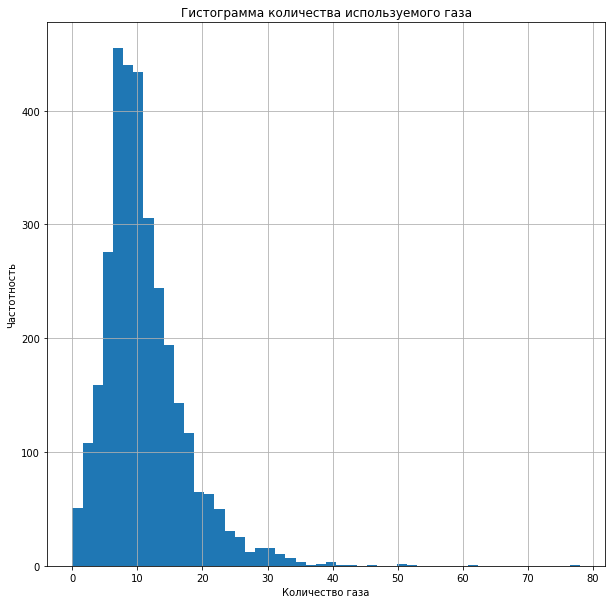

In [40]:
plt.rcParams['figure.figsize'] = [10, 10]
data_gas_new.hist(bins = 50, column = 'Газ 1')
plt.title('Гистограмма количества используемого газа')
plt.xlabel('Количество газа')
plt.ylabel('Частотность')
plt.show()

In [41]:
see(data_gas_new)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

key      0
Газ 1    0
dtype: int64

убрал

В данном датасете нету ошибок и пропусков, поэтому можно переходить к объединению таблиц

### Объединение всех таблиц

Нам нужно чтобы у нас заметчились абсолютно все ключи, поэтому будем использовать inner_join

In [42]:
data1 = pd.merge(data_temp_new, data_arc_new, on='key', how='inner')
data2 = pd.merge(data1, data_gas_new, on='key', how='inner')
wire_bulk = pd.merge(data_bulk_new, data_wire_new, on='key', how='inner')
data = pd.merge(data2, wire_bulk, on='key', how='inner')

In [43]:
see(data)

,key,first_temp,last_temp,melt_time,active_power_sum,reactive_power_sum,Газ 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
0,1,1571.0,1613.0,1714.0,3.036730,2.142821,29.749986,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000
1,2,1581.0,1602.0,1265.0,2.139408,1.453357,12.555561,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000
2,3,1596.0,1599.0,1753.0,4.063641,2.937457,28.554793,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000
3,4,1601.0,1625.0,1220.0,2.706489,2.056992,18.841219,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000
4,5,1576.0,1602.0,1536.0,2.252950,1.687991,5.413692,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456


,key,first_temp,last_temp,melt_time,active_power_sum,reactive_power_sum,Газ 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,1587.368761,1593.372633,2323.682014,3.126327,2.301280,11.378854,47.317126,37.347676,22.419535,208.597676,153.952668,120.078313,102.423900,17.613213
std,715.027927,23.627590,11.207457,1385.809791,1.220484,0.903711,6.397008,75.238050,58.677890,55.792509,157.112117,81.410544,84.655967,43.540975,33.648176
min,1.000000,1519.000000,1541.000000,339.000000,0.267676,0.196228,0.008399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,628.750000,1571.000000,1587.000000,1580.500000,2.295960,1.671099,7.282534,0.000000,0.000000,0.000000,105.000000,105.000000,0.000000,73.204559,0.000000
50%,1254.500000,1587.000000,1593.000000,2046.500000,3.036516,2.225900,10.100687,0.000000,0.000000,0.000000,206.000000,149.000000,107.000000,101.103600,0.000000
75%,1867.250000,1603.000000,1598.000000,2793.500000,3.834302,2.829180,14.218487,80.000000,77.250000,0.000000,283.000000,204.000000,204.000000,128.075222,23.102560
max,2499.000000,1660.000000,1653.000000,23674.000000,12.375636,8.949049,77.995040,454.000000,281.000000,503.000000,1849.000000,636.000000,405.000000,330.314424,282.780152


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2324 non-null   int64  
 1   first_temp          2324 non-null   float64
 2   last_temp           2324 non-null   float64
 3   melt_time           2324 non-null   float64
 4   active_power_sum    2324 non-null   float64
 5   reactive_power_sum  2324 non-null   float64
 6   Газ 1               2324 non-null   float64
 7   Bulk 3              2324 non-null   float64
 8   Bulk 4              2324 non-null   float64
 9   Bulk 6              2324 non-null   float64
 10  Bulk 12             2324 non-null   float64
 11  Bulk 14             2324 non-null   float64
 12  Bulk 15             2324 non-null   float64
 13  Wire 1              2324 non-null   float64
 14  Wire 2              2324 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 290.5 KB


None

key                   0
first_temp            0
last_temp             0
melt_time             0
active_power_sum      0
reactive_power_sum    0
Газ 1                 0
Bulk 3                0
Bulk 4                0
Bulk 6                0
Bulk 12               0
Bulk 14               0
Bulk 15               0
Wire 1                0
Wire 2                0
dtype: int64

Судя по сводной статистике, все показаели после объединения остались в норме, какие то странных значений замечено не было, можно переходить к делению на выборки и масштабированию

Теперь удалим ключ, чтобы он не мешал при обучении модели

In [44]:
data = data.drop(['key'], axis = 1)

Теперь проверим все признаки на мультиколиинеарность

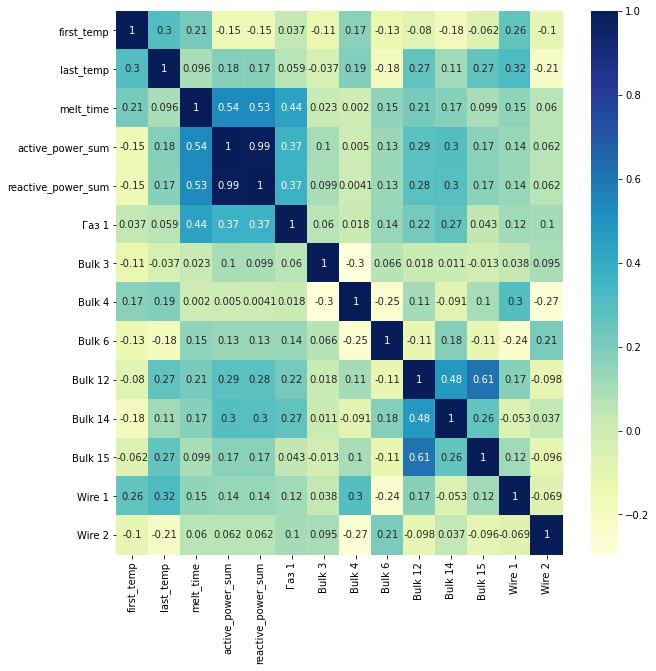

In [45]:
data_plot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)  
plt.show()

У нас имеется только 2 признака, которые сильно коррелируют между собой, это активная мощность и реактивная мощность, чтобы отобразить оба этих признака, я сделаю новый столбец из их суммы, а сами столбцы удалю

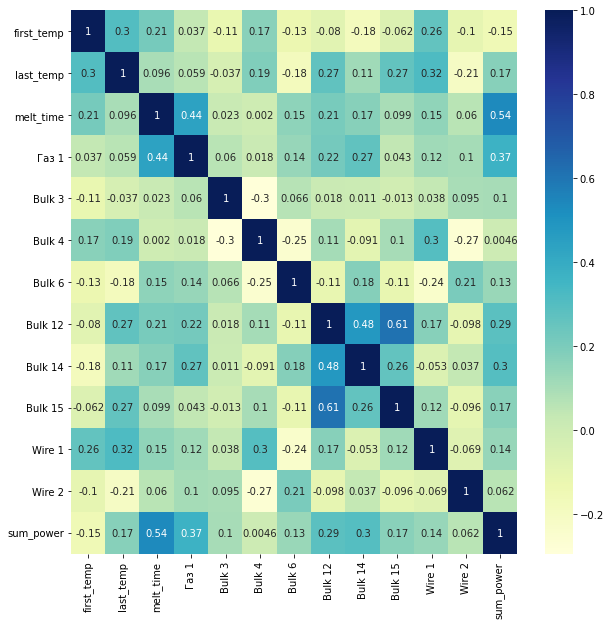

In [46]:
data['sum_power'] = data['active_power_sum'] + data['reactive_power_sum']
data = data.drop(['active_power_sum', 'reactive_power_sum'], axis = 1)
data_plot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)  
plt.show()

Мы избавились от слишком коррелирующих между собой признаками, теперь можно посмотреть распределение признаков

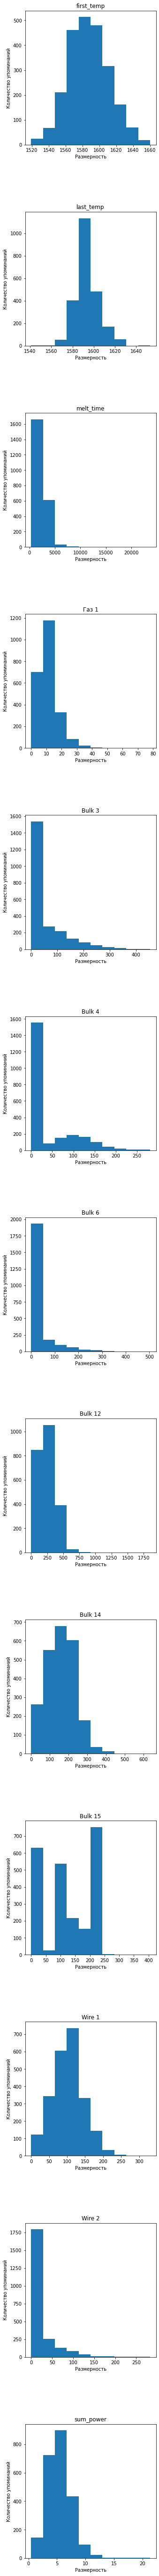

In [47]:
fig, axs = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(5, 100), gridspec_kw={'hspace': 0.5})

for i, col in enumerate(data.columns):
    axs[i].hist(data[col])
    axs[i].set_title(col)
    axs[i].set_ylabel('Количество упоминаний')
    axs[i].set_xlabel('Размерность')

plt.show()

На самом деле, на всех графиках видно, что почти все переменные кроме первой температуры скошены вправо, в случаях с присадками это не критично, но если говорить о времени плавления, то тут возможно стоит логарифмировать переменную, чтобы немного поправить распределние, но мне кажется в данном случае это делать не совсем правильно так как в данном случае выбросы играют большое значение

### Деление признаков и датасета

In [48]:
random_state = 250923

In [49]:
features = data.drop(['last_temp'],axis = 1)
target = data['last_temp']

In [50]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state = random_state)

In [51]:
features

,first_temp,melt_time,Газ 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Wire 1,Wire 2,sum_power
0,1571.0,1714.0,29.749986,0.0,43.0,0.0,206.0,150.0,154.0,60.059998,0.00000,5.179551
1,1581.0,1265.0,12.555561,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,0.00000,3.592765
2,1596.0,1753.0,28.554793,0.0,34.0,0.0,205.0,152.0,153.0,91.160157,0.00000,7.001098
3,1601.0,1220.0,18.841219,0.0,81.0,0.0,207.0,153.0,154.0,89.063515,0.00000,4.763481
4,1576.0,1536.0,5.413692,0.0,78.0,0.0,203.0,151.0,152.0,89.238236,9.11456,3.940941
...,...,...,...,...,...,...,...,...,...,...,...,...
2319,1570.0,1380.0,7.125735,21.0,0.0,0.0,256.0,129.0,223.0,89.150879,0.00000,5.379069
2320,1554.0,1705.0,9.412616,0.0,63.0,0.0,256.0,129.0,226.0,114.179527,0.00000,7.046949
2321,1571.0,962.0,6.271699,0.0,85.0,0.0,230.0,124.0,226.0,94.086723,9.04800,6.057331
2322,1591.0,1520.0,14.953657,90.0,0.0,0.0,206.0,129.0,207.0,118.110717,0.00000,5.442130


### Масштабирование признаков

In [52]:
numeric = ['first_temp', 'melt_time', 'sum_power', 'Газ 1', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Wire 1', 'Wire 2']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

In [53]:
best_model = None
best_score = 1000
best_estimator = None

### Random Forest

In [54]:
model_rf = RandomForestRegressor(random_state = random_state)
parametrs = { 'n_estimators': [50, 100, 150],
              'max_depth': [10 , 15]}
grid_rf = GridSearchCV(model_rf, parametrs, cv=3, scoring='neg_mean_absolute_error', n_jobs = -1)
grid_rf.fit(features_train, target_train)


if -grid_rf.best_score_ < best_score:
    best_score = -grid_rf.best_score_
    best_model = model_rf
    best_estimator = grid_rf.best_estimator_


print(grid_rf.best_params_)
print('MAE_random_forest =',-grid_rf.best_score_)

{'max_depth': 10, 'n_estimators': 150}
MAE_random_forest = 7.159740477698377


Точность данной модели получилась нормальная и MAE равна 7,17, позже сравним ее с константной моделью

### Cat Boost

In [55]:
model_cb = CatBoostRegressor(random_state = random_state, verbose = 50)
parametrs = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cb = GridSearchCV(model_cb, parametrs, cv=3, scoring='neg_mean_absolute_error', n_jobs = -1)
model_cb.fit(features_train, target_train)

if -model_cb.best_score_ < best_score:
    best_score = -model_cb.best_score_
    best_model = model_cb
    best_estimator = model_cb.best_estimator_

print(model_cb.best_params_)
print('MAE_catboost =',-model_cb.best_score_)

0:	learn: 11.2900992	total: 47.8ms	remaining: 4.73s
50:	learn: 10.1774395	total: 74ms	remaining: 71.1ms
99:	learn: 9.6423343	total: 96.5ms	remaining: 0us
0:	learn: 11.6640065	total: 635us	remaining: 62.9ms
50:	learn: 10.3230620	total: 23.9ms	remaining: 22.9ms
99:	learn: 9.7490720	total: 51.5ms	remaining: 0us
0:	learn: 10.9807243	total: 838us	remaining: 83ms
50:	learn: 9.8369838	total: 33ms	remaining: 31.7ms
99:	learn: 9.3481899	total: 59.3ms	remaining: 0us
0:	learn: 11.2135829	total: 595us	remaining: 59ms
50:	learn: 9.2355164	total: 24ms	remaining: 23.1ms
99:	learn: 8.6545331	total: 52.4ms	remaining: 0us
0:	learn: 11.5306306	total: 703us	remaining: 69.7ms
50:	learn: 9.3451267	total: 28.2ms	remaining: 27.1ms
99:	learn: 8.6749302	total: 49.8ms	remaining: 0us
0:	learn: 10.9007752	total: 717us	remaining: 71ms
50:	learn: 9.0066045	total: 23.8ms	remaining: 22.9ms
99:	learn: 8.5075305	total: 51.6ms	remaining: 0us
0:	learn: 11.2913654	total: 620us	remaining: 61.4ms
50:	learn: 10.1782726	total:

Здесь тоже получилась достаточно высокая точность (7,05), чуть получше чем у случайного леса, а значит тестировать на тестовой выборке мы будем Catboost

### Константная модель

In [56]:
const = DummyRegressor(strategy = 'mean')
const.fit(features_train, target_train)
predicts = const.predict(features_test)
scores = mean_absolute_error(target_test, predicts)
print('MAE константной модели:', scores)

MAE константной модели: 7.702888268095746


Точность константной модели получилась равна 7.7, результаты обоих предыдущих моделей получились лучше, а значит обе эти модели адекватны

## Проверка на тестовой выборке

In [57]:
predicts_cb = best_model.predict(features_test)
scores_cb = mean_absolute_error(target_test, predicts_cb)
print('MAE test random forest:', scores_cb)

MAE test random forest: 6.703898228056413


Извиняюсь, очень поздно было

При проверке модели на тестовой выборке точность получилась равна 6.7, это достаточно хороший результат, теперь самое время проверить важность каждого из признаков

In [58]:
best_estimator.feature_importances_ 

array([17.11435122, 10.94995308,  5.24616551,  3.09469741,  1.75110656,
        5.36963589, 10.19823316,  8.52076962,  9.61175338, 10.71834653,
        6.77985417, 10.64513347])

In [59]:
feature_importance = best_estimator.feature_importances_

,Важность
Признак,
first_temp,17.114351
melt_time,10.949953
Wire 1,10.718347
sum_power,10.645133
Bulk 12,10.198233
Bulk 15,9.611753
Bulk 14,8.520770
Wire 2,6.779854
Bulk 6,5.369636


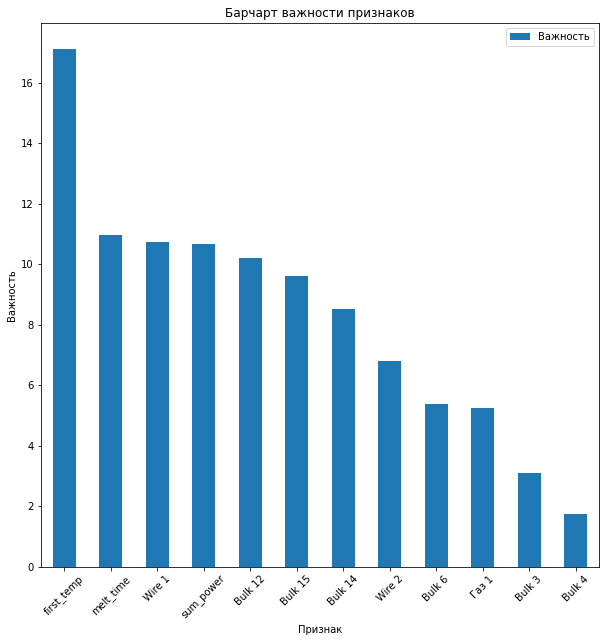

In [60]:
importance_df = pd.DataFrame({'Признак': features_train.columns, 'Важность': feature_importance})
importance_df = importance_df.sort_values(by='Важность', ascending=False).set_index('Признак')
importance_df.plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Барчарт важности признаков')
plt.xlabel('Признак')
plt.ylabel('Важность')
importance_df

Самый важный признак - это первая температура, второй признак - это время варки, третий - добавление булк присадки, 4 - также доавление присадки провода, и пятый - сумма активной и реактивной мощности

## Вывод

В ходе работы был проведен первичный анализ данных, в ходе которого были найдены и обработаны аномальные значения. Также  мы сформировали дополнительные признаки и соединили данные в единый датасет. Для нового большого датасета был повторно проведён анализ, в ходе которого не было замечено каких то аномалий. Далее данные были масштабированы признаки и обучены 3 модели: случайный лес, кэтбуст (градиентный бустинг), а также константная модель. При кросс-валидации лучший результат показал кэтбуст, MAE равно 7.05, на тесте он также показал хороший результат 6.5. MAE дамми модели равен 7.7, значит случайный лес прошёл тест на вменяемость. Клиенту рекомендуется использование именно кэтбуста, так как он показывает более точные результаты.

## Отчет

 - Из плана выполнены все пункты
 - В ходе работы было непросто понять сам производственный процесс и, следовательно, понять, какие признаки (изначальные и сгенерированные) будут наиболее полезными. После лекции большинство из этих моментов прояснилось, дополнительно удостовериться получилось после вывода наиболее важных признаков модели. Также возникли проблемы с обработкой данных о температуре, далеко не сразу понял что именно нужно было удалить, но спасибо руководителю, все стало ясно и понятноЮ очень ему благодарен
 - Были выделены следующие шаги: 
    1. Предобработка данных (удаление пропусков, фикс аномалий, возможно генерация каких то новых признаков)
    2. Объединение всех данных в один датафрейм (изначально у нас данные в нескольких)
    3. обработка данных в новом датафрейме (разделение на выборки, масштабирование при необходимости, выделение признаков)
    4. Далее мы будем готовы обучать модель, мои любимые модели это кэтбуст и случайный лес, их я и буду использовать вместе с гридсерчем.
    5. Далее проверим качество всех моделей и лучшую протестируем на тестовой выборке.

 - Из изначальных признаков были использованы все, кроме структурных (key) и мультиколлинеарных (реактивная мощность и активная мощность), также были удалены многие переменные отвечающие за добавление сыпучих присадок и все переменные отвечающие за добавление проводов кроме первого и второго. Были дополнительно сгенерированы признаки: полная мощность, общее время нагрева. Вместо набора температур для каждого key, данные были сагрегированны и мы создали два отдельных признака: первая и последняя температуры нагрева. Данные были проверены на аномалии, обработаны пропуски.
 - итоговый список признаков: первая температура плавки, время плавки, сумма активной и реактивной мощности, газ, сыпучая приставка 3, сыпучая приставка 4, сыпучая приставка 6, сыпучая приставка 12, сыпучая приставка 14, сыпучая приставка 15, добавка проводов 1, добавка проводов 2
 - Итоговая модель: CatBoost. Гиперпараметры = {'depth': 6, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.1}. Точность MAE на тесте = 6,7.
 - рекомендации по улучшению:
     1. хотелось бы больше данных без ошибок
     2. предсказание пропущеннных значений, думаю что если смоделировать модель для восстановления данных было бы оочень хорошо
     3. Возможно стоило добавить какое то количество категориальных признаков путем преобразования имеющихся столбцов
     4. Можно было бы использовать ансамблевое обучения, путем смешивая нескольких моделей машинного обучения
     5. Для моделей можно было бы попробовать больше гиперпараметров
     6. Все таки мне кажется что большинство проблем машинного обучения исходит из неверное трактовки данных, а также из за их недостоверности, при большем количестве температурных изменений а также при наличии каких то еще метрик, которые можно было бы измерить на производстве в достаточно высоком качестве качество модели точно можно было бы улучшить.
     7. Недостататочная вариативность исследуемых данных